In [77]:
from pathlib import Path
import json
import pandas as pd
import sys
from pathlib import Path
sys.path.append('../src')
from config import PROJECT_DIR, VOC_CLASSES, LABELS_DIR, TRUE_LABELS_CSV, RESULTS_DIR, HISTORIES_DIR
from experiment_config import experiments
import matplotlib.pyplot as plt

plt.style.use('default')
experiment_count = sum(len(experiments[exp]) for exp in experiments)

20

In [87]:
# Load all experiment results into a single dataframe

all_results = pd.DataFrame()
for file_path in RESULTS_DIR.glob("*.csv"):
    exp_title = file_path.stem
    df = pd.read_csv(file_path)
    df['experiment_set'] = exp_title
    all_results = pd.concat([all_results, df], ignore_index=True)
assert len(all_results) == experiment_count

In [88]:
# Load all history files into a list of dataframes
histories = []
for history_file in sorted(HISTORIES_DIR.glob("*.csv")):
    df = pd.read_csv(history_file)
    histories.append(df)
assert len(histories) == experiment_count

In [92]:
# Load all prediction files into a list of dataframes
predictions = []
for pred_file in sorted(LABELS_DIR.glob("*.csv")):
    if pred_file == TRUE_LABELS_CSV:
        continue
    df = pd.read_csv(pred_file)
    predictions.append(df)
assert len(predictions) == 20

In [ ]:
TEST_JSON = PROJECT_DIR / "data" / "preprocessed_jsons" / "test.json"

# Load test data
with open(TEST_JSON) as f:
    test_data = json.load(f)

# Process data to match the format of predicted.csv
true_labels_list = []
for item in test_data:
    image_name = item['file_path']
    labels = [0] * 20  # Assuming 20 possible labels
    for obj in item['object_labels']:
        label_index = VOC_CLASSES[obj['name']]
        labels[label_index] = 1
    true_labels_list.append([image_name] + labels)
    
# Create a DataFrame
true_labels_df = pd.DataFrame(true_labels_list, columns=['image_name'] + [str(i) for i in range(20)])

# Save to CSV
true_labels_df.to_csv(TRUE_LABELS_CSV, index=False)

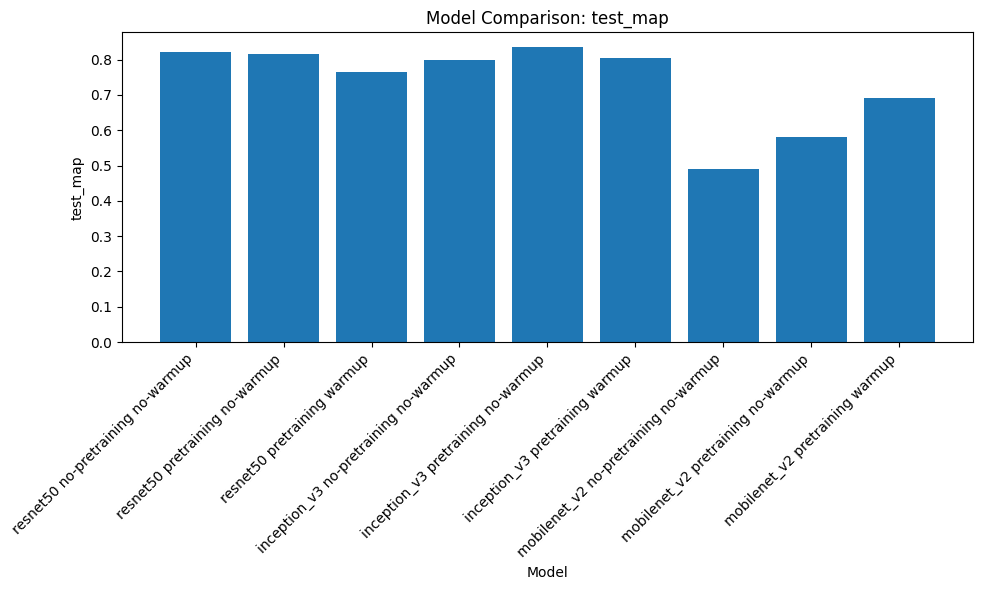

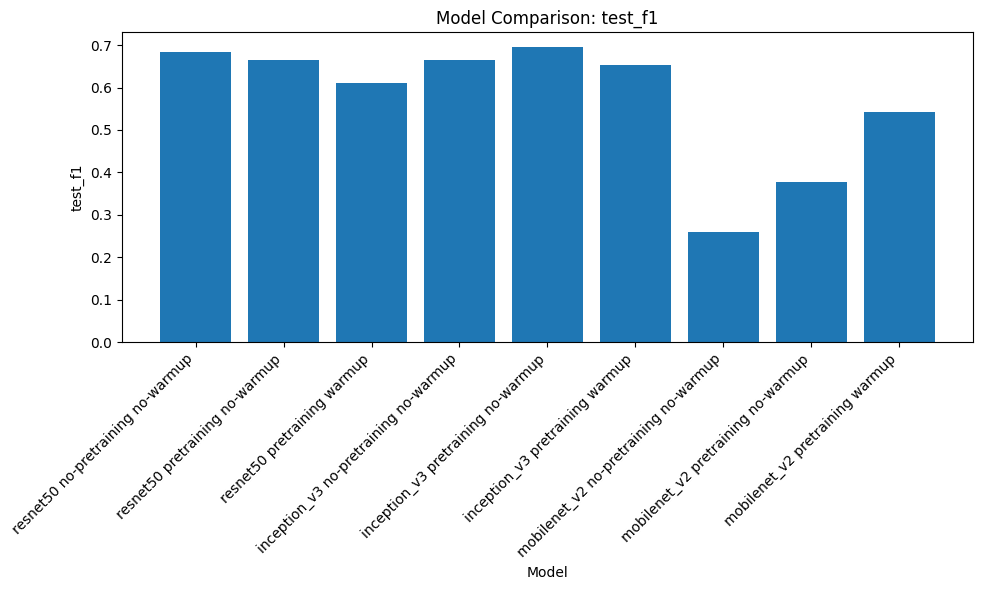

In [93]:
# Load model performance data
model_performance = all_results[all_results['experiment_set'] == 'model-experiments']

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(model_performance['title'], model_performance[metric])
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

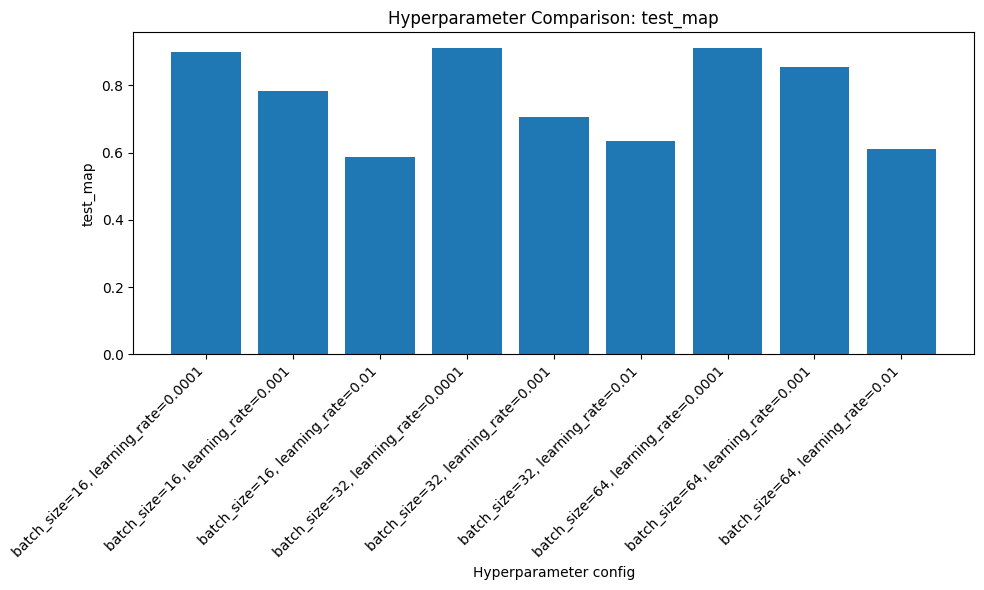

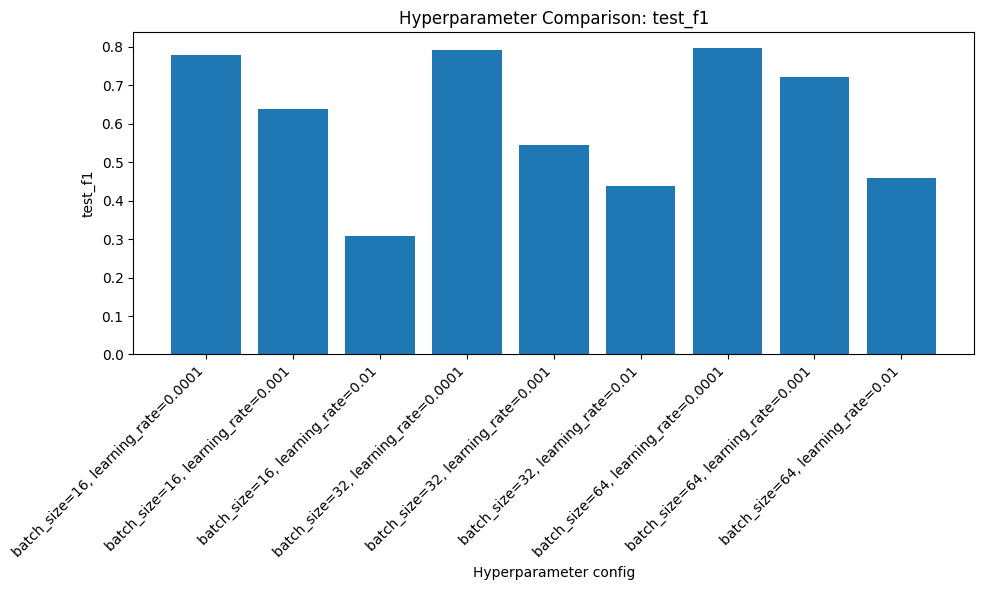

In [46]:
hyperparameter_performance_path = RESULTS_DIR / "hyperparameter-experiments.csv"
hyperparameter_performance = pd.read_csv(hyperparameter_performance_path)

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(hyperparameter_performance['title'], hyperparameter_performance[metric])
    plt.title(f'Hyperparameter Comparison: {metric}')
    plt.xlabel('Hyperparameter config')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

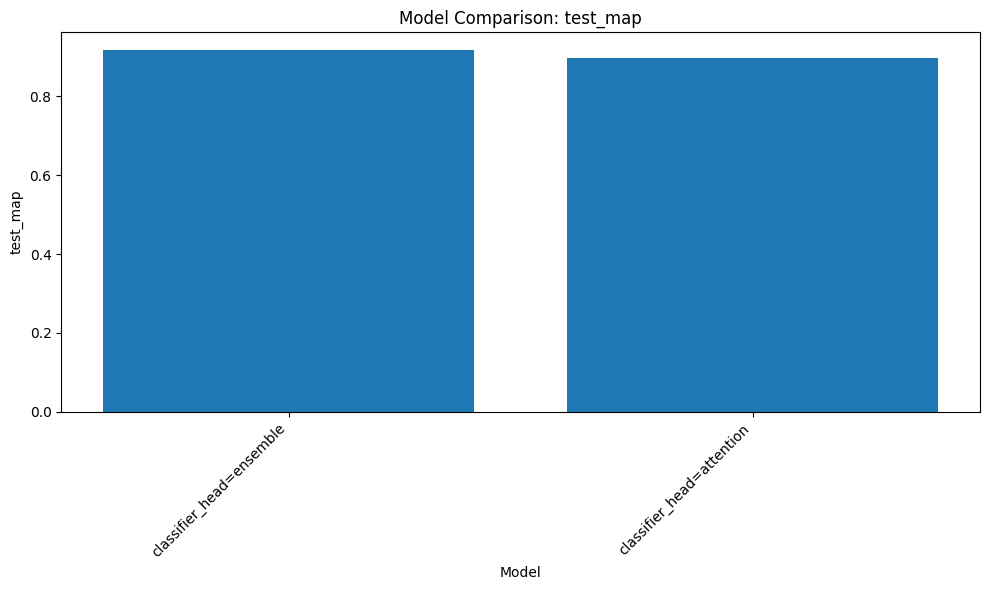

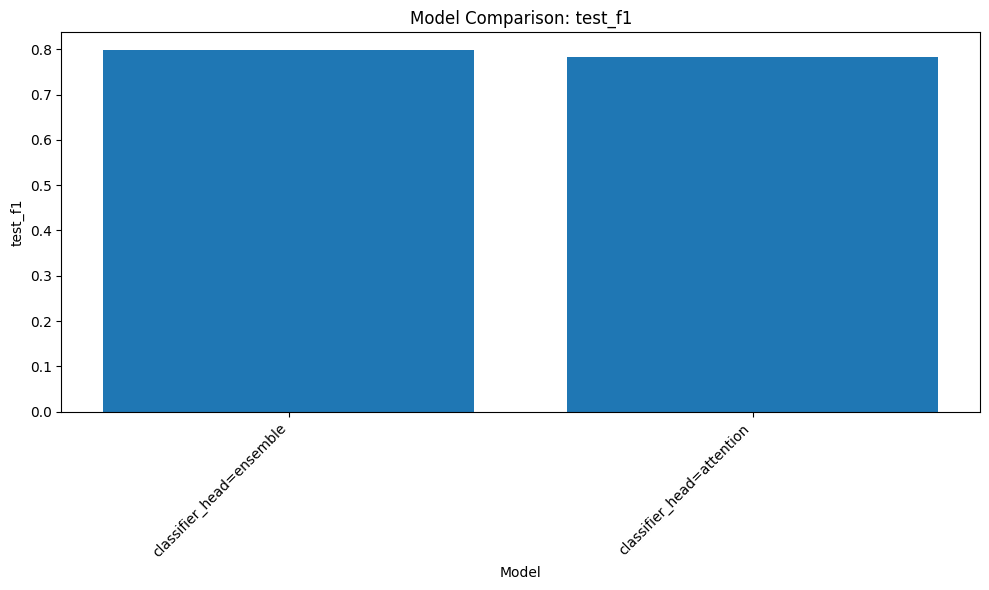

In [41]:
classifier_head_performance_path = RESULTS_DIR / "classifier_head-experiments.csv"
classifier_head_performance = pd.read_csv(classifier_head_performance_path)

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(classifier_head_performance['title'], classifier_head_performance[metric])
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

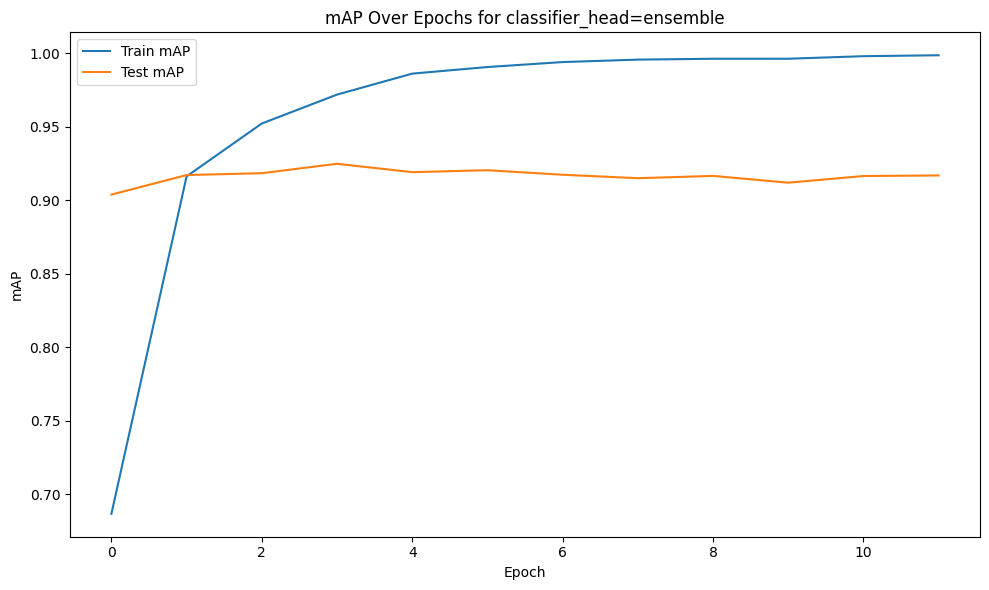

In [42]:
# Identify the best model based on F1 score
best_model_id = classifier_head_performance.loc[classifier_head_performance['test_f1'].idxmax(), 'id']
best_model_title = classifier_head_performance.loc[classifier_head_performance['test_f1'].idxmax(), 'title']

# Load history for the best model
history_path = HISTORIES_DIR / f"{best_model_id:02d}-{best_model_title}.csv"
history = pd.read_csv(history_path)

# Plot F1 scores over epochs
plt.figure(figsize=(10, 6))
plt.plot(history['train_map'], label='Train mAP')
plt.plot(history['test_map'], label='Test mAP')
plt.title(f'mAP Over Epochs for {best_model_title}')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Load predicted labels
predicted_labels_path = LABELS_DIR / f"{best_model_id:02d}-{best_model_title}.csv"
predicted_labels_df = pd.read_csv(predicted_labels_path)

In [45]:
# Get images which are present in both predicted and true labels
present_in_both = set(predicted_labels_df['image_name']) & set(true_labels_df['image_name'])

# Calculate false positives and false negatives
predicted = predicted_labels_df[predicted_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]
true = true_labels_df[true_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]

false_positives = ((predicted == 1) & (true == 0)).sum()
false_negatives = ((predicted == 0) & (true == 1)).sum()
true_positives = ((predicted == 1) & (true == 1)).sum()
true_negatives = ((predicted == 0) & (true == 0)).sum()

# Identify labels with highest false positives and negatives
highest_fp_label = false_positives.idxmax()
highest_fn_label = false_negatives.idxmax()

print(f"Label with highest false positives: {highest_fp_label}")
print(f"Label with highest false negatives: {highest_fn_label}")

# Generate a table of the false positives and negatives for each label
false_positives_table = pd.DataFrame({
    'Label': VOC_CLASSES.keys(),
    'False Positives': false_positives,
    'False Negatives': false_negatives,
    'True Positives': true_positives,
    'True Negatives': true_negatives,
    'Accuracy': (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives),
    'Precision': true_positives / (true_positives + false_positives),
    'Recall': true_positives / (true_positives + false_negatives),
    'F1 Score': 2 * (true_positives / (true_positives + false_positives)) * (true_positives / (true_positives + false_negatives)) / ((true_positives / (true_positives + false_positives)) + (true_positives / (true_positives + false_negatives))),
    'TP Rate': true_positives / (true_positives + false_negatives),
    'TN Rate': true_negatives / (true_negatives + false_positives),
    'FP Rate': false_positives / (true_positives + false_positives),
    'FN Rate': false_negatives / (true_negatives + false_negatives)
})
false_positives_table.sort_values(by='F1 Score', ascending=False, inplace=True)
false_positives_table

Label with highest false positives: 14
Label with highest false negatives: 14


,Label,False Positives,False Negatives,True Positives,True Negatives,Accuracy,Precision,Recall,F1 Score,TP Rate,TN Rate,FP Rate,FN Rate
14,person,716,755,1146,807,0.570386,0.615467,0.602841,0.609088,0.602841,0.529875,0.384533,0.483355
2,bird,128,141,15,3140,0.921437,0.104895,0.096154,0.100334,0.096154,0.960832,0.895105,0.042975
6,car,184,240,22,2978,0.876168,0.106796,0.083969,0.094017,0.083969,0.941809,0.893204,0.074580
11,dog,227,250,24,2923,0.860689,0.095618,0.087591,0.091429,0.087591,0.927937,0.904382,0.078790
7,cat,206,218,19,2981,0.876168,0.084444,0.080169,0.082251,0.080169,0.935362,0.915556,0.068146
1,bicycle,107,122,8,3187,0.933119,0.069565,0.061538,0.065306,0.061538,0.967517,0.930435,0.036869
8,chair,172,258,15,2979,0.874416,0.080214,0.054945,0.065217,0.054945,0.945414,0.919786,0.079703
5,bus,78,99,6,3241,0.948306,0.071429,0.057143,0.063492,0.057143,0.976499,0.928571,0.029641
0,aeroplane,120,134,8,3162,0.925818,0.062500,0.056338,0.059259,0.056338,0.963437,0.937500,0.040655
18,train,105,120,7,3192,0.934287,0.062500,0.055118,0.058577,0.055118,0.968153,0.937500,0.036232


## todo
- mAP for model experiments
    - heatmap or grouped bar plot
- mAP for hyperparameter experiments
    - heatmap or grouped bar plot
    - 3 learning rates and 3 batch sizes
    - for batch size, compare 3 learning rates
    - ideally show all 9 in one plot, not too busy
- mAP for augmentation experiments
    - history plot showing how augmentation reduces overfitting
- mAP for imbalance experiments
    - heatmap showing mAP for each class before and after balancing
- mAP for classifier head experiments
    - shows a less biased output
    - history, train vs test of default and ensemble
    - you could see that the ensemble has a lower overfitting
- subset accuracy for the best model
- confusion matrix / stats for the best model
